In [1]:
import pandas as pd
import numpy as np
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
pd.reset_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 500)


warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import StopWordsRemover # PySpark currently does not directly support automatic stop word lists for languages other than English
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as F

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

In [19]:
df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/commits')

In [20]:
df = df.select("subject", "message").sample(withReplacement=False, fraction=0.00002, seed=42)

In [21]:
df.count()

5306

### Clean the data

In [22]:
# Add an 'id' column to df: the IDs are not necessarily consecutive but are guaranteed to be unique across the entire DataFrame.
df_text = df.withColumn("id", monotonically_increasing_id())

# Remove punctuation and split into words
df_text = df_text.withColumn("clean_subject", F.regexp_replace(F.col("subject"), "[^a-zA-Z0-9\\s]", ""))
df_text = df_text.withColumn("subject_words", split(F.col("clean_subject"), " "))
df_text = df_text.withColumn("clean_message", F.regexp_replace(F.col("message"), "[^a-zA-Z0-9\\s]", ""))
df_text = df_text.withColumn("clean_message", F.regexp_replace(F.col("clean_message"), "\n", " "))
df_text = df_text.withColumn("message_words", split(F.col("clean_message"), " "))

# Filter out tokens that are less than 3 characters
df_text = df_text.withColumn("clean_s", F.expr("filter(subject_words, word -> length(word) >= 3)"))
df_text = df_text.withColumn("clean_m", F.expr("filter(message_words, word -> length(word) >= 3)"))

# Remove stopwords for subject
remover_subject_words = StopWordsRemover(inputCol="clean_s", outputCol="filtered_subject")
df_text = remover_subject_words.transform(df_text)

# For the 'message_words' column
remover_message_words = StopWordsRemover(inputCol="clean_m", outputCol="filtered_message")
df_text = remover_message_words.transform(df_text)

display(df_text.select('id', 
                  'subject', 
                  'clean_subject', 
                  'subject_words', 
                  'filtered_subject',
                  'message',
                  'clean_message',
                  'message_words',
                  'filtered_message').limit(5).toPandas())

# Keep only the variables we need
df_text = df_text.select('id','subject','filtered_subject', "message", "filtered_message")

,id,subject,clean_subject,subject_words,filtered_subject,message,clean_message,message_words,filtered_message
0,17179869184,New package: librealsense_jll v2.31.0+0 (#7407),New package librealsensejll v23100 7407,"[New, package, librealsensejll, v23100, 7407]","[New, package, librealsensejll, v23100, 7407]",New package: librealsense_jll v2.31.0+0 (#7407)\n\nUUID: 65edd895-dc1e-518e-896c-dc343a3c7f2e\r\nRepo: https://github.com/JuliaBinaryWrappers/librealsense_jll.jl.git\r\nTree: 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r\n\r\nRegistrator tree SHA: unknown,New package librealsensejll v23100 7407 UUID 65edd895dc1e518e896cdc343a3c7f2e\r Repo httpsgithubcomJuliaBinaryWrapperslibrealsensejlljlgit\r Tree 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r \r Registrator tree SHA unknown,"[New, package, librealsensejll, v23100, 7407, , UUID, 65edd895dc1e518e896cdc343a3c7f2e\r, Repo, httpsgithubcomJuliaBinaryWrapperslibrealsensejlljlgit\r, Tree, 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r, \r, Registrator, tree, SHA, unknown]","[New, package, librealsensejll, v23100, 7407, UUID, 65edd895dc1e518e896cdc343a3c7f2e\r, Repo, httpsgithubcomJuliaBinaryWrapperslibrealsensejlljlgit\r, Tree, 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r, Registrator, tree, SHA, unknown]"
1,17179869185,review of ios inapp,review of ios inapp,"[review, of, ios, inapp]","[review, ios, inapp]",review of ios inapp\n,review of ios inapp,"[review, of, ios, inapp, ]","[review, ios, inapp]"
2,25769803776,fix notes service unittest,fix notes service unittest,"[fix, notes, service, unittest]","[fix, notes, service, unittest]",fix notes service unittest\n,fix notes service unittest,"[fix, notes, service, unittest, ]","[fix, notes, service, unittest]"
3,34359738368,Merge branch 'preview' of https://github.com/Azure/azure-powershell into preview,Merge branch preview of httpsgithubcomAzureazurepowershell into preview,"[Merge, branch, preview, of, httpsgithubcomAzureazurepowershell, into, preview]","[Merge, branch, preview, httpsgithubcomAzureazurepowershell, preview]",Merge branch 'preview' of https://github.com/Azure/azure-powershell into preview\n,Merge branch preview of httpsgithubcomAzureazurepowershell into preview,"[Merge, branch, preview, of, httpsgithubcomAzureazurepowershell, into, preview, ]","[Merge, branch, preview, httpsgithubcomAzureazurepowershell, preview]"
4,42949672960,Merge tag '1flow-0.21.2' into develop,Merge tag 1flow0212 into develop,"[Merge, tag, 1flow0212, into, develop]","[Merge, tag, 1flow0212, develop]",Merge tag '1flow-0.21.2' into develop\n\n0.21.2 1flow-0.21.2\n,Merge tag 1flow0212 into develop 0212 1flow0212,"[Merge, tag, 1flow0212, into, develop, , 0212, 1flow0212, ]","[Merge, tag, 1flow0212, develop, 0212, 1flow0212]"


### Vectorize words

In [23]:
vectorize_subject = CountVectorizer(inputCol="filtered_subject", outputCol="subject_features", minDF=1.0)
vectorize_message = CountVectorizer(inputCol="filtered_message", outputCol="message_features", minDF=1.0)
df_vectorize = vectorize_subject.fit(df_text).transform(df_text)
df_vectorize = vectorize_message.fit(df_vectorize).transform(df_vectorize)
display(df_vectorize.limit(5).toPandas())

,id,subject,filtered_subject,message,filtered_message,subject_features,message_features
0,17179869184,New package: librealsense_jll v2.31.0+0 (#7407),"[New, package, librealsensejll, v23100, 7407]",New package: librealsense_jll v2.31.0+0 (#7407)\n\nUUID: 65edd895-dc1e-518e-896c-dc343a3c7f2e\r\nRepo: https://github.com/JuliaBinaryWrappers/librealsense_jll.jl.git\r\nTree: 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r\n\r\nRegistrator tree SHA: unknown,"[New, package, librealsensejll, v23100, 7407, UUID, 65edd895dc1e518e896cdc343a3c7f2e\r, Repo, httpsgithubcomJuliaBinaryWrapperslibrealsensejlljlgit\r, Tree, 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r, Registrator, tree, SHA, unknown]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,17179869185,review of ios inapp,"[review, ios, inapp]",review of ios inapp\n,"[review, ios, inapp]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,25769803776,fix notes service unittest,"[fix, notes, service, unittest]",fix notes service unittest\n,"[fix, notes, service, unittest]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,34359738368,Merge branch 'preview' of https://github.com/Az

### Fit Minhash to create hash table

In [24]:
from pyspark.ml.linalg import Vectors

# Function to check if a vector has non-zero entries
def vector_non_zero(v):
    return any([x != 0 for x in v])

# Register the function as a UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

non_zero_udf = udf(lambda v: vector_non_zero(v), BooleanType())

# Filter out rows with empty vectors
df_vectorize = df_vectorize.filter((non_zero_udf(col("subject_features"))) & (non_zero_udf(col("subject_features"))))

In [25]:
mh = MinHashLSH(inputCol="subject_features", outputCol="subject_hashes", numHashTables=5)
model_subject = mh.fit(df_vectorize)

mh2 = MinHashLSH(inputCol="message_features", outputCol="message_hashes", numHashTables=5)
model_message = mh2.fit(df_vectorize)

df_hashed_text = mh.fit(df_vectorize).transform(df_vectorize)
df_hashed_text = mh2.fit(df_hashed_text).transform(df_hashed_text).cache()

display(df_hashed_text.limit(5).toPandas())

,id,subject,filtered_subject,message,filtered_message,subject_features,message_features,subject_hashes,message_hashes
0,17179869184,New package: librealsense_jll v2.31.0+0 (#7407),"[New, package, librealsensejll, v23100, 7407]",New package: librealsense_jll v2.31.0+0 (#7407)\n\nUUID: 65edd895-dc1e-518e-896c-dc343a3c7f2e\r\nRepo: https://github.com/JuliaBinaryWrappers/librealsense_jll.jl.git\r\nTree: 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r\n\r\nRegistrator tree SHA: unknown,"[New, package, librealsensejll, v23100, 7407, UUID, 65edd895dc1e518e896cdc343a3c7f2e\r, Repo, httpsgithubcomJuliaBinaryWrapperslibrealsensejlljlgit\r, Tree, 5c14d87ffcafec1566a906d8ef63d9cb9826083b\r, Registrator, tree, SHA, unknown]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[389054535.0], [52719276.0], [818912386.0], [35777088.0], [172232384.0]]","[[17689555.0], [136432750.0], [208798748.0], [75003623.0], [5438877.0]]"
1,17179869185,review of ios inapp,"[review, ios, inapp]",review of ios inapp\n,"[review, ios, inapp]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[27764414.0], [46164746.0], [1259696431.0], [644126866.0], [630127437.0]]","[[724109135.0], [600174860.0], [200777034.0], [1116149432.0], [130137170.0]]"
2,25769803776,fix notes service unittest,"[fix, notes, service, unittest]",fix notes service unittest\n,"[fix, notes, service, unittest]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

### Establish similarity threshold and return near-duplicate records

In [26]:
df_subject = df_hashed_text.select(['id', 'subject','subject_features', 'subject_hashes'])
df_message = df_hashed_text.select(['id', 'message','message_features', 'message_hashes'])

#### Jaccard Distance = 0.5 for both subject and message

In [27]:
jaccard_distance = 0.5

df_dups_message = model_message.approxSimilarityJoin(df_message, df_message, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.message').alias('messsage_A'),
            col('datasetB.message').alias('message_B'))

In [28]:
df_message_50 = df_dups_message
df_dups_message.cache()
df_dups_message.limit(20).toPandas()

,distCol,id_A,id_B,messsage_A,message_B
0,0.40,13924283973633,19954418057217,Merge branch 'master' of https://github.com/Serg28/tsvshop\n,Merge branch 'master' of https://github.com/jackli439/jdesign2\n
1,0.40,13924283973633,13984413515779,Merge branch 'master' of https://github.com/Serg28/tsvshop\n,Merge branch 'master' of https://github.com/ProjectSynchro/naev into master\n
2,0.40,14877766713345,22935125360641,Merge branch 'master' into gh-pages\n,Merge branch 'master' of git@github.com:marshall/titanium\n
3,0.00,10411000725504,12532714569730,updated gitignore\n\n,updated .gitignore\n
4,0.40,9612136808448,13924283973633,Merge branch 'master' of https://github.com/ExpressBaseSystems/ExpressBase.Web\n,Merge branch 'master' of https://github.com/Serg28/tsvshop\n
5,0.00,412316860416,19335942766594,Update README.md,Update README.md
6,0.00,7997229105152,15298673508353,update\n,update\n
7,0.40,11708080848896,25512105738240,Merge branch 'master' of github.com:sebastianhoffmann/querybuilder\n,Merge branch 'master' of github.com:soomla/ios-profile\n
8,0.00,6030134083589,15298673508353,update,update\n
9,0.00,14319420964866,25460566130688,Initial commit\n,Initial commit.\n


In [44]:
records = df_hashed_text.count()
dups = df_dups_message.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5235
Duplicate texts based on { 0.5 } jaccard distance:  404
Unique texts based on { 0.5 } jaccard distance:  0.5 :  4831


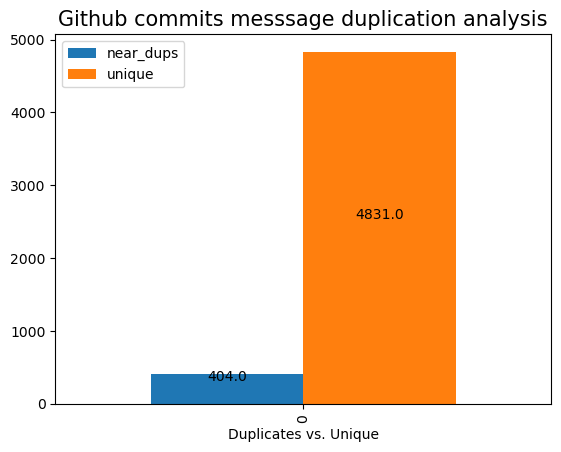

In [45]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Github commits messsage duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [37]:
df_dups_text = model_subject.approxSimilarityJoin(df_subject, df_subject, jaccard_distance).filter("datasetA.id < datasetB.id").select(
               col("distCol"),
               col("datasetA.id").alias("id_A"),
               col("datasetB.id").alias("id_B"),
               col('datasetA.subject').alias('subject_A'),
               col('datasetB.subject').alias('subject_B'))

In [38]:
df_subject_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(20).toPandas()

,distCol,id_A,id_B,subject_A,subject_B
0,0.400000,1803886264320,25271587569664,Merge pull request #24 from gitter-badger/gitter-badge,Merge pull request #24 from iskvmk/feature/start_with_rails_server
1,0.400000,1803886264320,13383118094336,Merge pull request #24 from gitter-badger/gitter-badge,Merge pull request #59 from slix/broken-askyn-on-windows
2,0.400000,5884105195521,25744033972225,Merge pull request #6 from johnynek/addbenchmarks,Merge pull request #56 from haiwen/seaf-cli-json-01
3,0.250000,14645838479365,16827681865728,Merge branch 'master' into swift3,Merge branch 'master' into master
4,0.333333,22634477649921,25718264168451,Merge branch '3.2',Merge branch '2020-02-07-master-imports'
5,0.000000,10849087389696,21620865368064,Initial commit,Initial commit
6,0.000000,10642928959489,12068858101760,Add files via upload,Add files via upload
7,0.000000,20907900796930,26276609916928,Update README.md,Update README.md
8,0.000000,2748779069441,4612794875905,Initial commit,Initial commit.
9,0.400000,8486855376896,12558484373505,Merge pull request #5 from phile314/agda,Merge pull request #72 from semool/patch-v050-gtk3


In [40]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5235
Duplicate texts based on { 0.5 } jaccard distance:  555
Unique texts based on { 0.5 } jaccard distance:  0.5 :  4680


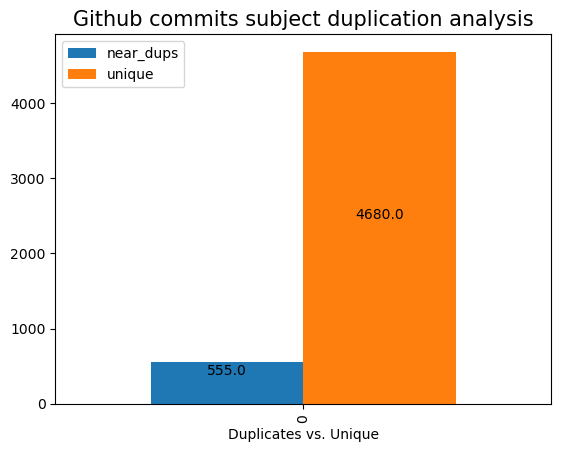

In [43]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Github commits subject duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### From the analysis above, I found that there were not many duplicates, less than 10% of the sample, with more subject duplicates than message duplicates under 0.5 jaccard distance. I also noticed that besides simply copy and paste every word, many duplicates were made by using the same phrase with the change of their own repository name or subject name.